## Setup

In [8]:
import string
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.axes import Axes
from matplotlib.gridspec import GridSpec
from scipy.stats import pearsonr, normaltest
import country_converter as coco
import seaborn as sns
from scipy.stats import pearsonr

sns.set_theme(context="paper", style="ticks", font="Arial", font_scale=1.0)
cc = coco.CountryConverter()

In [19]:
def plot_reg(x, y, ax):
    x = x.to_numpy()
    y = y.to_numpy()
    m, b = np.polyfit(x, y, 1)
    r, p = pearsonr(x, y)
    y_pred = m * x + b
    ax.plot(x, y_pred, linewidth=1.0, linestyle="dashed", color="gray")
    ax.annotate(
        f"r={round(r, 3)}, p={round(p, 3)}",
        xy=(x[-1], y_pred[-1]),
        fontsize=7,
        ha="left",
        va="top",
        xytext=(-5, 0),
        textcoords="offset points",
        bbox=dict(boxstyle="square", ec="white", fc="white"),
    )


def index_subplots(
    axs: Axes,
    font_size: float = 20,
    font_weight: str = "bold",
    font_family: str = rcParams["font.family"],
    x: float = -0.1,
    y: float = 1.1,
    uppercase: bool = False,
    prefix: str = "",
    suffix: str = "",
    offset: int = 0,
):
    int_to_char_map = string.ascii_lowercase
    if uppercase:
        int_to_char_map = string.ascii_uppercase

    for i, ax in enumerate(axs):
        ax.text(
            x,
            y,
            prefix + int_to_char_map[i + offset] + suffix,
            transform=ax.transAxes,
            size=font_size,
            weight=font_weight,
            fontfamily=font_family,
        )

### Load Data

#### UN Data

In [20]:
# Source: http://data.uis.unesco.org/
df_demo = pd.read_csv("country_stats/un_demographics.csv", usecols=["Indicator", "Country", "Time", "Value"])
df_rnd = pd.read_csv("country_stats/un_rnd.csv", usecols=["Indicator", "Country", "Time", "Value"])

df_demo_gdp = df_demo[df_demo.Indicator == "GDP (current US$)"]
df_demo_pop = df_demo[df_demo.Indicator == "Total population (thousands)"]

df_rnd_res = df_rnd[df_rnd.Indicator == "Researchers per million inhabitants (FTE)"]
df_rnd_erd = df_rnd[df_rnd.Indicator == "GERD as a percentage of GDP"]

df_demo_gdp = df_demo_gdp.rename(columns={"Value": "GDP"})
df_demo_pop = df_demo_pop.rename(columns={"Value": "Population"})

df_rnd_res = df_rnd_res.rename(columns={"Value": "Researchers_per_mil"})
df_rnd_erd = df_rnd_erd.rename(columns={"Value": "GERT_percentage_gdp"})

df_demo_gdp.drop(columns=["Indicator"], inplace=True)
df_demo_pop.drop(columns=["Indicator"], inplace=True)

df_rnd_res.drop(columns=["Indicator"], inplace=True)
df_rnd_erd.drop(columns=["Indicator"], inplace=True)

df = pd.merge(df_rnd_erd, df_rnd_res, on=["Country", "Time"], how="inner")
df = pd.merge(df, df_demo_pop, on=["Country", "Time"], how="inner")
df = pd.merge(df, df_demo_gdp, on=["Country", "Time"], how="inner")

df["GDP_per_capita"] = df.GDP / (df.Population * 1000)
df["Spending"] = (df.GERT_percentage_gdp / 100) * df.GDP
df["Researchers"] = (df.Population / 1000) * df.Researchers_per_mil
df["Spending_per_researcher"] = df.Spending / df.Researchers

df.Country = cc.convert(names=df.Country.replace("Ha�ti", "Haiti"), to="ISO3", not_found="Unknown")

df = df.sort_values("Time").groupby(["Country"]).tail(1).reset_index()

#### Crossref Collaboration Data

In [21]:
# Source: Crossref
df_collab = pd.concat([
    pd.read_csv("bibliometrics/papers/crossref/affiliations/affiliations_Google.csv"),
    pd.read_csv("bibliometrics/papers/crossref/affiliations/affiliations_Nvidia.csv"),
    pd.read_csv("bibliometrics/papers/crossref/affiliations/affiliations_Facebook.csv"),
    pd.read_csv("bibliometrics/papers/crossref/affiliations/affiliations_DeepMind.csv")
])

def get_country(x):
    x = str(x)
    vals = x.split()
    if vals[-1].isnumeric():
        return vals[-2]
    return vals[-1]

df_collab["country"] = df_collab.address.apply(get_country)
df_collab["country"] = df_collab.country.replace("nan", "Unknown").replace("States", "USA")
df_collab = df_collab[["company", "country"]].groupby(["company", "country"])
df_collab = df_collab.size().reset_index().rename(columns={0: "count"})

# df_collab.sort_values(by="count").tail(20)

In [22]:
# https://www.nasdaq.com/articles/which-companies-spend-the-most-in-research-and-development-rd-2021-06-21
# https://www.fool.com/investing/2021/05/20/nvidias-24-billion-advantage-over-amd/

# Employees
# https://en.wikipedia.org/wiki/List_of_largest_technology_companies_by_revenue
# https://www.macrotrends.net/stocks/charts/NVDA/nvidia/number-of-employees

companies = [
    {"Company": "Amazon", "Spending": 42740000000, "Employees": 147000},
    {"Company": "Alphabet", "Spending": 27570000000, "Employees": 135301},
    {"Company": "Microsoft", "Spending": 19270000000, "Employees": 163000},
    {"Company": "Apple", "Spending": 18750000000, "Employees": 147000},
    {"Company": "Facebook", "Spending": 18450000000, "Employees": 58604},
    {"Company": "Nvidia", "Spending": 3920000000, "Employees": 22473},
]

Amazon
    Country      Spending
26      BRA  3.118463e+10
109     ITA  2.897110e+10
50      CAN  2.891284e+10
11      AUS  2.723068e+10
81      CHE  2.302770e+10
101     NLD  2.096617e+10
112     SWE  1.909002e+10
89      BEL  1.814616e+10
110     ESP  1.801011e+10
48      IND  1.771200e+10
------
Alphabet
    Country      Spending
11      AUS  2.723068e+10
81      CHE  2.302770e+10
101     NLD  2.096617e+10
112     SWE  1.909002e+10
89      BEL  1.814616e+10
110     ESP  1.801011e+10
48      IND  1.771200e+10
93      RUS  1.628925e+10
96      AUT  1.386982e+10
85      DNK  1.054560e+10
------
Microsoft
    Country      Spending
112     SWE  1.909002e+10
89      BEL  1.814616e+10
110     ESP  1.801011e+10
48      IND  1.771200e+10
93      RUS  1.628925e+10
96      AUT  1.386982e+10
85      DNK  1.054560e+10
104     POL  8.305309e+09
103     NOR  8.251045e+09
126     FIN  7.918388e+09
------
Apple
    Country      Spending
89      BEL  1.814616e+10
110     ESP  1.801011e+10
48      IND

### Plots

#### Funding per Country and Researcher

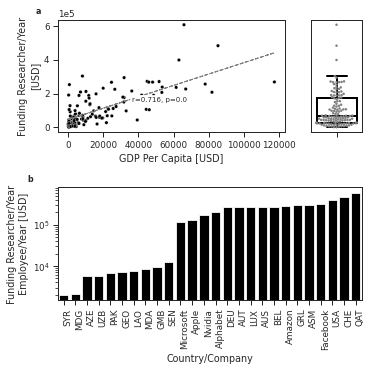

In [23]:
fig = plt.figure(facecolor="white", figsize=(1.5 * 3.5039, 1.5 * 3.5039))
gs = GridSpec(2, 3, width_ratios=[1, 1, 0.5])
ax0 = fig.add_subplot(gs[0, :-1])
ax1 = fig.add_subplot(gs[0, 2])
ax2 = fig.add_subplot(gs[1, :])

sns.scatterplot(data=df, x="GDP_per_capita", y="Spending_per_researcher", color="black", size=2.5, ax=ax0)
ax0.set_xlabel("GDP Per Capita [USD]")
ax0.set_ylabel("Funding Researcher/Year\n[USD]")
ax0.ticklabel_format(style="sci", scilimits=(-3, 4), axis="y")
ax0.legend([],[], frameon=False)
plot_reg(df["GDP_per_capita"], df["Spending_per_researcher"], ax0)

sns.boxplot(
    y=df["Spending_per_researcher"], color="white", linewidth=2,
    medianprops=dict(color="black"),
    boxprops=dict(edgecolor="black"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    showfliers=False, ax=ax1
)
sns.swarmplot(data=df, y="Spending_per_researcher", color="0.5", size=2.5, ax=ax1)
ax1.set_yticks([])
ax1.set_ylabel("")

df_companies = pd.DataFrame(companies).rename(columns={"Company": "Country"})
df_companies["Spending_per_researcher"] = df_companies["Spending"] / df_companies["Employees"]


df_top_bottom = pd.concat([
    df.sort_values(by="Spending_per_researcher").head(10)[["Country", "Spending_per_researcher"]], 
    df.sort_values(by="Spending_per_researcher").tail(10)[["Country", "Spending_per_researcher"]],
    df_companies[["Country", "Spending_per_researcher"]]
]).sort_values(by="Spending_per_researcher")


# companies
# df_top_bottom = df_top_bottom

sns.barplot(data=df_top_bottom, x="Country", y="Spending_per_researcher", color="black", ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, ha="left")
ax2.set_ylabel("Funding Researcher/Year\nEmployee/Year [USD]")
ax2.set_xlabel("Country/Company")
ax2.set_yscale("log")

index_subplots([ax0, ax2], font_size=8, y=1.05)
plt.tight_layout()

plt.savefig("figure_countries.svg")
plt.savefig("figure_countries.eps")